<h2 style="font-family: Times New Roman; text-align: center">Legged Locomotion of Robots Labor Project</h2> 
<h3 style="font-family: Times New Roman; text-align: center">Prof. Dr. Koelewijn</h3>
<h4 style="font-family: Times New Roman; text-align: center">Farzam Taghipour (ub21abuq)</h4>
<h4 style="font-family: Times New Roman; text-align: center"><a href="mailto:farzam.taghipour@fau.de">farzam.taghipour@fau.de</a></h4>
<h4 style="font-family: Times New Roman; text-align: center"><a href="https://github.com/FarzamTP/Replicating-Human-Joint-Moments-Using-Neural-Networks">Code in GitHub</a></h4>
<h5 style="font-family: Times New Roman; text-align: center">Winter Semester 23/24</h5>

# Replicating Human Joint Moments Using Neural Networks

## Project Description

* The goal of this project is to compare different input combinations:
    
    1. Only using the joint angle of the joint for which you are creating the controller
    2. All joint angles
    3. Both these options combined with the ground reaction force
    
* The idea is that, if only ***one joint angle*** is sufficient, then less sensors will be required in a prosthesis or exoskeleton, which makes them cheaper and less prone to failure.


## Scientific Questions to Answer

* We want to answer these questions:

    1. Is analyzing a single feature (e.g. Ankle joint angle) is sufficient to predict the joint moment?
    2. How different features are related to each other?
    3. Do we need all features to simulate and predict the joint moment?
    4. How complex models need to be to have a decent performance?
    5. How many paramethers does a neural network should have to perform well?
    6. Does a deep neural network (non-convolutional model) can perform as well as a convolutional neural network?
    7. As data are time-specific, how does recurrent neural networks perform on these data?
    8. Does more paramethers always result to a better performance in above recurrent neural model?
    9. How does long short-term memory networks (LSTM) models perform?
    10. Does a bi-directional neural network model enhance the performance?


# Project Implementation

## Importing Necessary Libraries

* `scipy` to read `mat` files.
* `numpy` to work with arrays.
* `pandas` to convert data into `dataframes`
* `matplotlib` for plotting plots and points.
* `seaborn` to plot heatmaps for correlation matrix.
* `sklearn` to use machine learning algorithms like `LinearRegression` and `DecisionTreeRegressor`
* `Tensorflow` to work with `Keras` to create and train neural networks.
* `datetime` to compute elapsed execution time.

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"

import shutil
import scipy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from itertools import combinations
from sklearn import svm
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

from IPython.display import Markdown as md

tf.get_logger().setLevel("ERROR")

## Reading data

* we can use `scipy.io.loadmat` to read and convert `.mat` files into readable `dict` in python.

In [2]:
# Extracting the ankle data from mat file
data_array = scipy.io.loadmat('data/Data_Ankle.mat')['ankle_data']

In [3]:
# Converts the data array into pandas dataframe with corresponding column names
data = pd.DataFrame(data_array, columns=['time', 'vertical_ground_reaction_force',
                                         'trunk_joint_angle', 'hip_joint_angle',
                                         'knee_joint_angle', 'ankle_joint_angle',
                                         'joint_moment'])

In [4]:
# Check if the data is missing
data.isnull().sum()

time                              0
vertical_ground_reaction_force    0
trunk_joint_angle                 0
hip_joint_angle                   0
knee_joint_angle                  0
ankle_joint_angle                 0
joint_moment                      0
dtype: int64

In [5]:
data.head()

time  vertical_ground_reaction_force  trunk_joint_angle  hip_joint_angle  \
0  0.00                      -10.321381          -0.094286         0.292974   
1  0.01                       -7.990312          -0.096174         0.293179   
2  0.02                       -6.208738          -0.096449         0.294008   
3  0.03                       -5.126637          -0.097196         0.295568   
4  0.04                       -4.774037          -0.095624         0.297472   

   knee_joint_angle  ankle_joint_angle  joint_moment  
0          0.825063          -1.492588     -2.011628  
1          0.822469          -1.493192     -3.655209  
2          0.810997          -1.495867     -5.786433  
3          0.785731          -1.501793     -6.190008  
4          0.745707          -1.511208     -5.542868

In [6]:
EPOCHS = 1000
BATCH_SIZE = 4096

## Plotting Features

* If we plot the data all together as points, we cannot actually understand the details as there are 48000 dataoints. For this purpose, we should define a time window and plot the data in that time frame.

In [7]:
def plot_feature_per_time(feature_name, title, label, window_size=500):
    """
    Plots given features with their desired label for y-axis, alongside the window-size

    @param feature_name: (str) the feature's name we want to plot w.r.t target `Joint Moment`.
    @param title: (str) the plot's title.
    @param label: (str) the label we want to set for the y-axis.
    @param window_size: (int) the window-size for which we want to plot first data.

    @return: None
    """
    plt.axhline(y=data[feature_name].min(), color='r', linestyle='--', label='Min Angle')
    plt.axhline(y=data[feature_name].max(), color='g', linestyle='--', label='Max Angle')
    
    plt.plot(data.time[:window_size], data[feature_name][:window_size])
    plt.title(title)
    plt.ylabel(label)
    plt.xlabel('Time (s)')
    plt.legend()
    plt.grid()
    plt.show()

### Trunk Joint Angle's Periodic Cycle

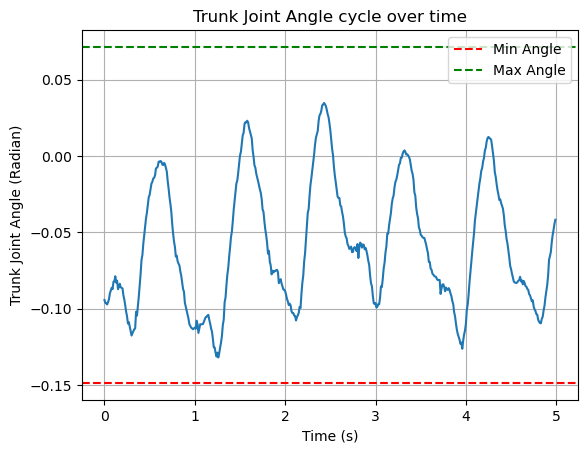

In [8]:
plot_feature_per_time(feature_name='trunk_joint_angle', title='Trunk Joint Angle cycle over time', label='Trunk Joint Angle (Radian)')

### Hip Joint Angle's Periodic Cycle

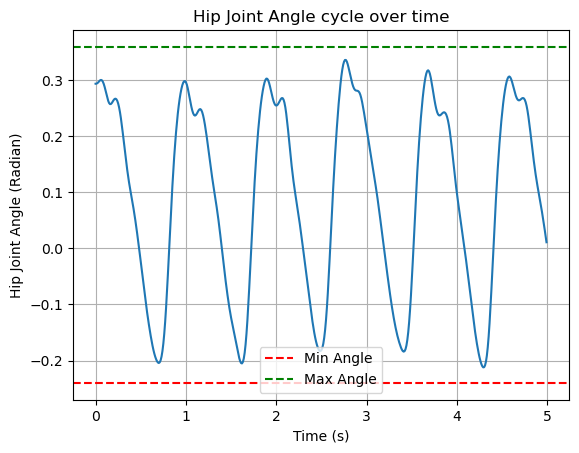

In [9]:
plot_feature_per_time(feature_name='hip_joint_angle', title='Hip Joint Angle cycle over time', label='Hip Joint Angle (Radian)')

### Knee Joint Angle's Periodic Cycle

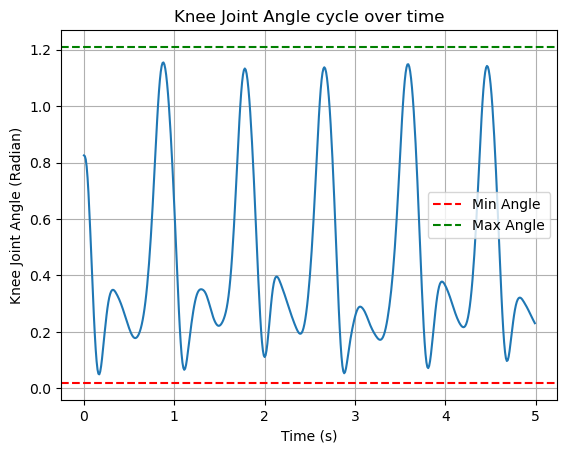

In [10]:
plot_feature_per_time(feature_name='knee_joint_angle', title='Knee Joint Angle cycle over time', label='Knee Joint Angle (Radian)')

### Ankle Joint Angle's Periodic Cycle

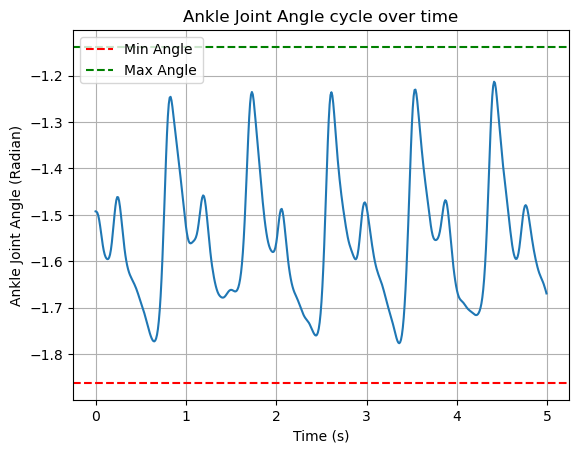

In [11]:
plot_feature_per_time(feature_name='ankle_joint_angle', title='Ankle Joint Angle cycle over time', label='Ankle Joint Angle (Radian)')

### BoxPlot for better understanding

* A Box Plot is the visual representation of the statistical five number summary of a given data set.

      Five Number Summary includes:

    1. Minimum
    2. First Quartile
    3. Median (Second Quartile)
    4. Third Quartile
    5. Maximum


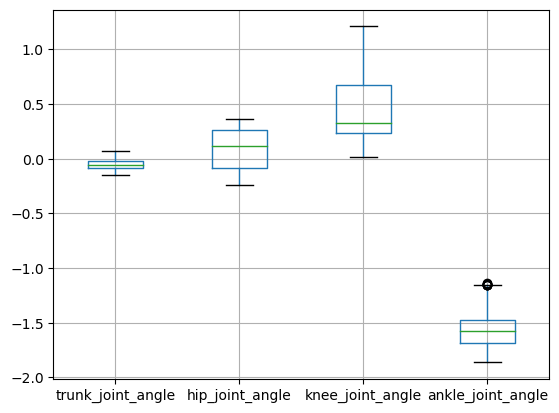

In [12]:
data.boxplot(column=['trunk_joint_angle', 'hip_joint_angle', 'knee_joint_angle', 'ankle_joint_angle'])
plt.show()

## Normalizing Data
* we can normalize the data using the `MinMaxScaler` method, to make sure selected features have the same range.

In [13]:
columns_to_normalize = ['trunk_joint_angle', 'hip_joint_angle', 'knee_joint_angle', 'ankle_joint_angle']

normalized_data = data.copy()

normalized_data[columns_to_normalize] = preprocessing.MinMaxScaler().fit_transform(data[columns_to_normalize])
normalized_data.head()

time  vertical_ground_reaction_force  trunk_joint_angle  hip_joint_angle  \
0  0.00                      -10.321381           0.246712         0.890431   
1  0.01                       -7.990312           0.238134         0.890774   
2  0.02                       -6.208738           0.236884         0.892159   
3  0.03                       -5.126637           0.233489         0.894766   
4  0.04                       -4.774037           0.240635         0.897949   

   knee_joint_angle  ankle_joint_angle  joint_moment  
0          0.677080           0.510548     -2.011628  
1          0.674900           0.509714     -3.655209  
2          0.665259           0.506018     -5.786433  
3          0.644027           0.497827     -6.190008  
4          0.610393           0.484816     -5.542868

### Normalized BoxPlot

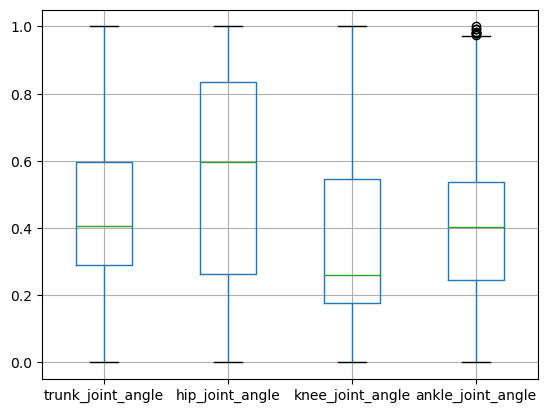

In [14]:
normalized_data.boxplot(column=['trunk_joint_angle', 'hip_joint_angle', 'knee_joint_angle', 'ankle_joint_angle'])
plt.show()

## Correlation Matrix

* Since the the look periodic, we may assume that some features may be correlated somehow. To test this, we can use the `corr()` method to calculate the correlation between selected features.

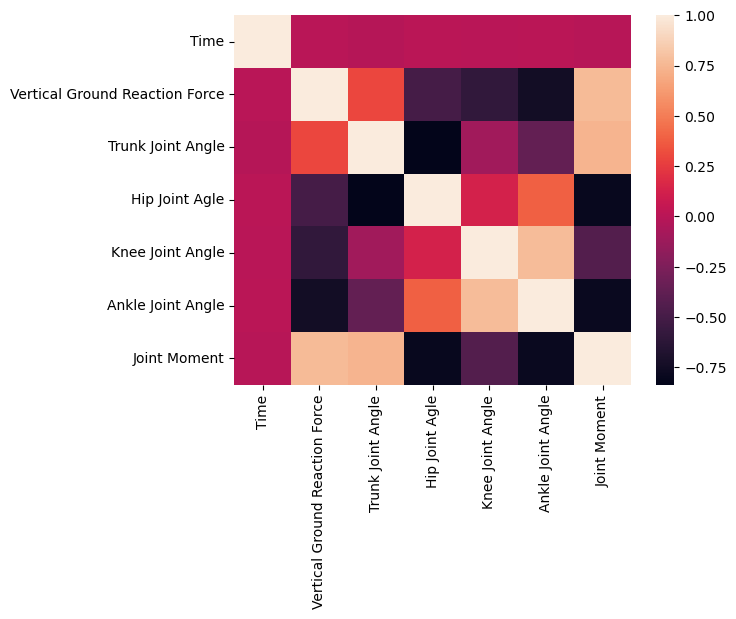

In [15]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

axis_labels = ['Time', 'Vertical Ground Reaction Force', 'Trunk Joint Angle', 'Hip Joint Agle', 'Knee Joint Angle', 'Ankle Joint Angle', 'Joint Moment']

sns.heatmap(corr, xticklabels=axis_labels, yticklabels=axis_labels)

plt.show()

* It can be observed that some features have high correlation with each other (close to 1 or -1). For example, `Trunk Joint Angle` and `Hip Joint Angle` are clearly correlated. To see it better, we can plot them together to see how they behave.

## Plots to Show Correlations

### Hip Joint Angle vs. Trunk Joint Angle

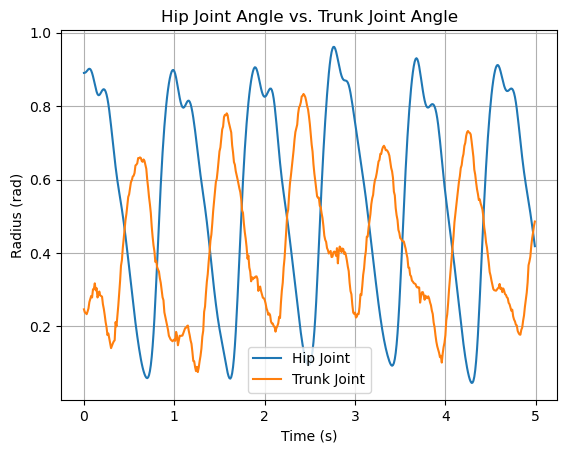

In [16]:
plt.plot(normalized_data.time[:500], normalized_data.hip_joint_angle[:500], label='Hip Joint')
plt.plot(normalized_data.time[:500], normalized_data.trunk_joint_angle[:500], label='Trunk Joint')
plt.title('Hip Joint Angle vs. Trunk Joint Angle')
plt.xlabel('Time (s)')
plt.ylabel('Radius (rad)')
plt.legend()
plt.grid()
plt.show()

* By taking a look at the above plot, we can easily spot that `Hip Joint Angle` and `Trunk Joint Angle` are behaving somehow contradictory.

### Verical Ground Reaction Force vs. Joint Moment

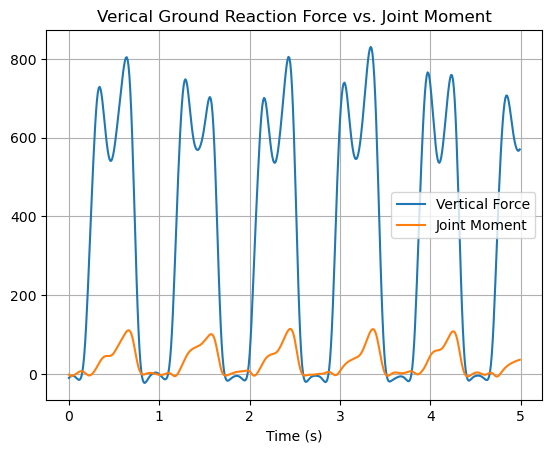

In [17]:
plt.plot(normalized_data.time[:500], normalized_data.vertical_ground_reaction_force[:500], label='Vertical Force')
plt.plot(normalized_data.time[:500], normalized_data.joint_moment[:500], label='Joint Moment')
plt.title('Verical Ground Reaction Force vs. Joint Moment')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()

* The same statement can be applied to `Vetical Ground Reaction Force` and `Joint Moment`. They behave the same in the defined time periods, as they rise and fall together.

### Hip Joint Angle vs. Ankle Joint Angle

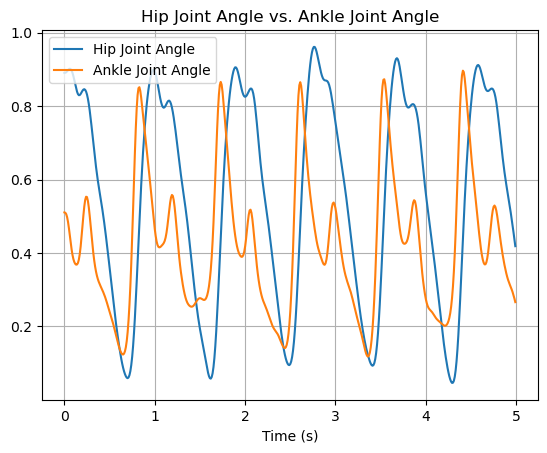

In [18]:
plt.plot(normalized_data.time[:500], normalized_data.hip_joint_angle[:500], label='Hip Joint Angle')
plt.plot(normalized_data.time[:500], normalized_data.ankle_joint_angle[:500], label='Ankle Joint Angle')
plt.title('Hip Joint Angle vs. Ankle Joint Angle')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()

* As shown above, there is almost no correlation between `Hip Joint Angle` and `Ankle Joint Angle`.

### Correlation Conclusion

* As shown above, some of the mentioned features are highly correlated and we can omit them for our estimations as they are redundant, and have almost ***no effect*** on the model's performance by training different models with every feature and one time without correlated features.

## PDP Plots

* Partial dependence shows how a particular feature affects a prediction. By making all other features constant, we want to find out how the feature in question influences our outcome.

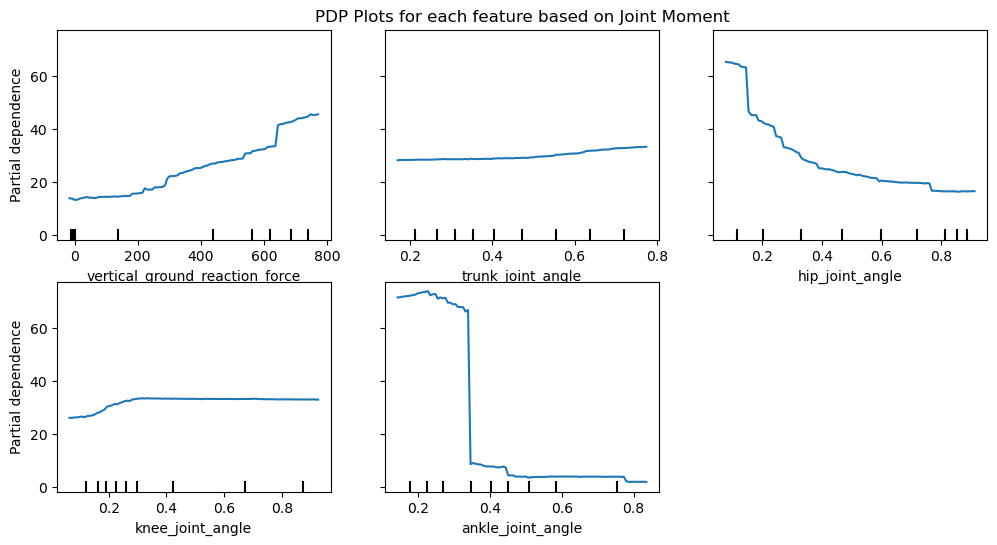

In [19]:
X_normalized = normalized_data.drop(columns=['time', 'joint_moment'])
y = normalized_data.joint_moment

features = X_normalized.columns

clf = DecisionTreeRegressor()

clf.fit(X_normalized, y)

fig, ax = plt.subplots(figsize=(12, 6))

plt.title('PDP Plots for each feature based on Joint Moment')
PartialDependenceDisplay.from_estimator(clf, X_normalized, features, ax=ax)
plt.show()

* When Partial Dependence Plots (PDPs) appear almost continuously horizontal, it generally suggests that the relationship between the predictor variable being examined and the target variable is ***weak*** or ***nearly nonexistent***. In other words, the predictor variable ***does not*** have a significant impact on the target variable, at least within the range of values explored in the PDP.

## ICE Plots

* An ICE plot visualizes the dependence of the prediction on a feature for each instance separately, resulting in one line per instance, compared to one line overall in partial dependence plots. A PDP is the average of the lines of an ICE plot.

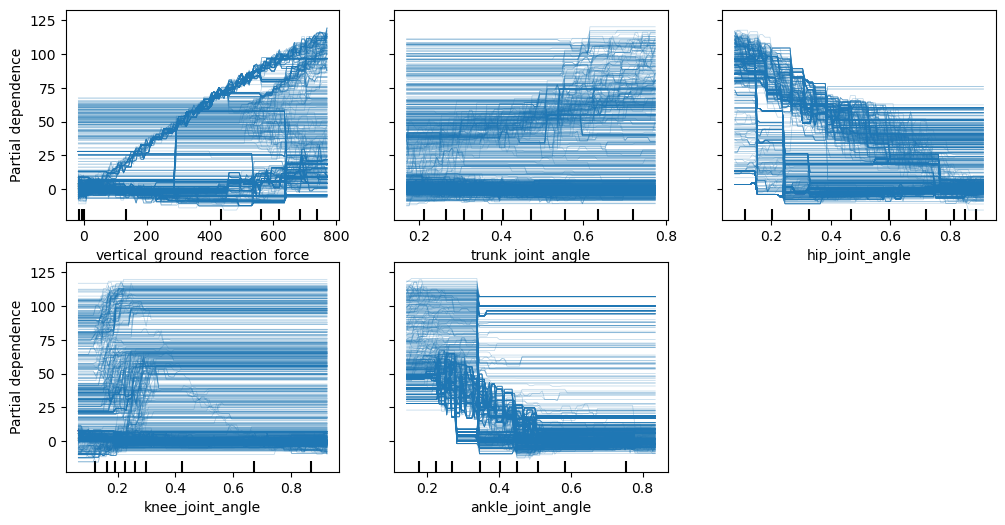

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

PartialDependenceDisplay.from_estimator(clf, X_normalized, features, ax=ax, kind='individual')
plt.show()

### Importnat Notes Regarding the ICE Plots

![Image](plots/results/ICE-Plot-Annotated.jpeg)

* As we can see in the above plot, there are some individuals that behave differently with respect to the target feature `Joint Moment`. I interpret these individuals as perturbations in the data.

## Splitting Data Regardless of Time-Series Properties

In [21]:
X = data.drop(columns=['time', 'joint_moment'])
X_norm = normalized_data.drop(columns=['time', 'joint_moment'])

y = data.joint_moment
y_norm = normalized_data.joint_moment

np.random.seed(42)

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_norm, X_test_norm = X_norm.iloc[train_index], X_norm.iloc[test_index]
    y_train_norm, y_test_norm = y_norm.iloc[train_index], y_norm.iloc[test_index]
    
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print("=================================")

print(f"X_train_norm shape: {X_train_norm.shape}")
print(f"y_train_norm shape: {y_train_norm.shape}")

print(f"X_test_norm shape: {X_test_norm.shape}")
print(f"y_test_norm shape: {y_test_norm.shape}")

X_train shape: (40000, 5)
y_train shape: (40000,)
X_test shape: (8000, 5)
y_test shape: (8000,)
X_train_norm shape: (40000, 5)
y_train_norm shape: (40000,)
X_test_norm shape: (8000, 5)
y_test_norm shape: (8000,)


## Linear Models
    
    1. LinearRregression
    2. DecisionTreeRegressor
    3. RandomForestRegressor
    4. Lasso
    5. Ridge
    6. BayesianRidge

### Linear Regression

In [22]:
LR = LinearRegression()

t0 = datetime.datetime.now()

LR.fit(X_train, y_train)

t1 = datetime.datetime.now()

LR_elapsed_time = (t1 - t0).total_seconds()

LR_score = LR.score(X_test, y_test)

LR.fit(X_train_norm, y_train_norm)

normalized_LR_score = LR.score(X_test_norm, y_test_norm)

print(f"Elapsed Time: {LR_elapsed_time} (s)")
print(f"Linear Regression Score: {LR_score} %, Normalized Data Score: {normalized_LR_score} %")

Elapsed Time: 0.005309 (s)
Linear Regression Score: 0.9469798304861906 %, Normalized Data Score: 0.946979830486175 %


### Decision Tree Regressor

In [23]:
regression_tree = DecisionTreeRegressor()

t0 = datetime.datetime.now()

regression_tree.fit(X_train, y_train)

t1 = datetime.datetime.now()

decision_tree_elapsed_time = (t1 - t0).total_seconds()

decision_tree_score = regression_tree.score(X_test, y_test)

regression_tree.fit(X_train_norm, y_train_norm)

normalized_regression_tree_score = regression_tree.score(X_test_norm, y_test_norm)

print(f"Elapsed Time: {decision_tree_elapsed_time} (s)")
print(f"Decision Tree Regressor Score: {decision_tree_score} %, Normalized Data Score: {normalized_regression_tree_score} %")

Elapsed Time: 0.270438 (s)
Decision Tree Regressor Score: 0.9815719908676451 %, Normalized Data Score: 0.9814885245545175 %


### Random Forest Regressor

In [24]:
random_forest_regressor = RandomForestRegressor()

t0 = datetime.datetime.now()

random_forest_regressor.fit(X_train, y_train)

t1 = datetime.datetime.now()

random_forest_elapsed_time = (t1 - t0).total_seconds()

random_forest_score = random_forest_regressor.score(X_test, y_test)

random_forest_regressor.fit(X_train_norm, y_train_norm)

normalized_random_forest_score = random_forest_regressor.score(X_test_norm, y_test_norm)

print(f"Elapsed Time: {random_forest_elapsed_time} (s)")
print(f"Random Forest Regressor Score: {random_forest_score} %, Normalized Data Score: {normalized_random_forest_score} %")

Elapsed Time: 14.045563 (s)
Random Forest Regressor Score: 0.9901083208981434 %, Normalized Data Score: 0.9901232369892404 %


### Lasso

In [25]:
lasso = Lasso()

t0 = datetime.datetime.now()

lasso.fit(X_train, y_train)

t1 = datetime.datetime.now()

lasso_elapsed_time = (t1 - t0).total_seconds()

lasso_score = lasso.score(X_test, y_test)

lasso.fit(X_train_norm, y_train_norm)

normalized_lasso_score = lasso.score(X_test_norm, y_test_norm)

print(f"Elapsed Time: {lasso_elapsed_time} (s)")
print(f"Lasso Regressor Score: {lasso_score} %, Normalized Data Score: {normalized_lasso_score} %")

Elapsed Time: 0.006505 (s)
Lasso Regressor Score: 0.8002536993169895 %, Normalized Data Score: 0.874415990082045 %


### Ridge Regressor

In [26]:
ridge = Ridge()

t0 = datetime.datetime.now()

ridge.fit(X_train, y_train)

t1 = datetime.datetime.now()

ridge_elapsed_time = (t1 - t0).total_seconds()

ridge_score = ridge.score(X_test, y_test)

ridge.fit(X_train_norm, y_train_norm)

normalized_ridge_score = ridge.score(X_test_norm, y_test_norm)

print(f"Elapsed Time: {ridge_elapsed_time} (s)")
print(f"Ridge Regressor Score: {ridge_score} %, Normalized Data Score: {normalized_ridge_score} %")

Elapsed Time: 0.004506 (s)
Ridge Regressor Score: 0.9468560941847006 %, Normalized Data Score: 0.9469747591779285 %


### Bayesian Ridge

In [27]:
baysian = BayesianRidge()

t0 = datetime.datetime.now()

baysian.fit(X_train, y_train)

t1 = datetime.datetime.now()

baysian_elapsed_time = (t1 - t0).total_seconds()

baysian_score = baysian.score(X_test, y_test)

baysian.fit(X_train_norm, y_train_norm)

normalized_baysian_score = baysian.score(X_test_norm, y_test_norm)

print(f"Elapsed Time: {baysian_elapsed_time} (s)")
print(f"Bayesian Ridge Regressor Score: {baysian_score} %, Normalized Data Score: {normalized_baysian_score} %")

Elapsed Time: 0.017016 (s)
Bayesian Ridge Regressor Score: 0.9469794185295899 %, Normalized Data Score: 0.9469797291257593 %


In [28]:
text = f"""### Normalization Results

* We can see that normalizing data **mostly** doesn't affect the models' performance except for `Lasso` that increased the score from ~**{round(lasso_score, 3)} %** to ~**{round(normalized_lasso_score, 3)} %**.
"""

md(text)

### Normalization Results

* We can see that normalizing data **mostly** doesn't affect the models' performance except for `Lasso` that increased the score from ~**0.8 %** to ~**0.874 %**.


## Neural Network

## Feature Space Selection

* Based on the above analysis, we will now select different sub-spaces of our feature space to check which combined features perform as well as all features combined?

### Model Re-defining

* Models carry weights after they are trained, to reset them we need to re-define them.

In [29]:
def reset_models(num_features):
    
    # Redefining linear models
    LR = LinearRegression()
    DTR = DecisionTreeRegressor()
    RFR = RandomForestRegressor()
    lasso = Lasso()
    ridge = Ridge()
    baysian = BayesianRidge()
    
    redefined_models = [LR, DTR, RFR, lasso, ridge, baysian]
#   =====================================================
    try:
        nn_model = keras.Sequential([
            keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(num_features, 1)),
            keras.layers.MaxPooling1D(pool_size=2),
            keras.layers.Flatten(),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(1, activation='linear')
        ], name='Cnn_Model')

        nn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
        
        redefined_models.append(nn_model)
    except Exception as err:
        print(f"VALUE ERROR [CNN Model]: {err}")
    
#   =====================================================    
    rnn_model = keras.Sequential([
        keras.layers.SimpleRNN(units=32, activation='relu', input_shape=(num_features, 1)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ], name='Rnn_Model')
    
    redefined_models.append(rnn_model)

    rnn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
#   =====================================================
    lstm_model = keras.Sequential([
        keras.layers.LSTM(units=16, return_sequences=True, input_shape=(num_features, 1)),
        keras.layers.TimeDistributed(keras.layers.Dense(16, activation='relu')),
        keras.layers.Flatten(),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='linear')
    ], name='LSTM_Model')
    
    redefined_models.append(lstm_model)
    
    lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
#   =====================================================
    bi_directional_lstm_model = keras.Sequential([
        keras.layers.Bidirectional(keras.layers.LSTM(units=8, return_sequences=True), input_shape=(num_features, 1)),
        keras.layers.TimeDistributed(keras.layers.Dense(16, activation='relu')),
        keras.layers.Flatten(),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='linear')
    ], name='LSTM_Bidirectional_Model')
    
    bi_directional_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
#   =====================================================
    redefined_models.append(bi_directional_lstm_model)
    
    return redefined_models

In [30]:
def generate_feature_selection_table(feature_results):
    """
    Generates a Markdown table for the the given feature_results list.
    
    @param: (list) feature_results: containing dictionary data of training process, containing 'features', 'model_name', 'mse', and 'elapsed_time' for each feature subspace.
    @return: Markdown Table
    """
    
    text = f"""
| Feature(s) Name | Model Name | Mean Square Error | Elapsed Time (s) |
| :-: | :-: | :-: | :-: |\n"""

    prev_line = ''
    minimum_mse_row = feature_results[0]
    
    for result in feature_results:
            
        if prev_line == result['features']:
            text += f"| | {result['model_name']} | {result['mse']} | {result['elapsed_time']} |\n"
        else:
            name = str(result['features']).replace('[', '').replace(']', '').replace("'", "")
            text += f"| {name} | {result['model_name']} | {result['mse']} | {result['elapsed_time']} |\n"
            prev_line = result['features']
        
        if result['mse'] < minimum_mse_row['mse']:
            minimum_mse_row = result
    
    return md(text)

In [31]:
def plot_history(history, title):
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()

In [32]:
def plot_prediction_ground_truth_best_model(feature_results, models, X_test, y_test):
    """
    Generates the plot for interactive comparison between ground truth and the prediction for the best model's performance over the feature subspace.
    
    @param: (list) feature_results: containing dictionary data of training process, containing 'features', 'model_name', 'mse', and 'elapsed_time' for each feature subspace.
    @param: (list) models: list of trained models over the mentioned feature subspace.
    @param: (list) X_test: the test data used for validation.
    @paran: (list) y_test: the test labels used for validation.
    
    @return: Markdown Table
    """
    
    minimum_mse_row = feature_results[0]
    
    for result in feature_results:
        if result['mse'] < minimum_mse_row['mse']:
            minimum_mse_row = result
    
    if minimum_mse_row['history']:
        plot_history(history, f"MSE loss for {minimum_mse_row['model_name']}")
    
    for model in models:
        try:
            # CNN, RNN, LSTM, Bi-directional LSTM
            model_name = model.name
        except:
            # LR, DTR, RFR, Lasso, Ridge, BayesianRidge
            model_name = type(model).__name__
        
        if model_name == minimum_mse_row['model_name']:
            prediction = model.predict(X_test).flatten()
            name = str(minimum_mse_row['features']).replace('[', '').replace(']', '').replace("'", "")

            fig = go.Figure()
            
            fig.add_trace(go.Scatter(x=np.linspace(0, len(y_test), len(y_test)), y=list(y_test), name='Ground Truth'))
            fig.add_trace(go.Scatter(x=np.linspace(0, len(prediction), len(prediction)), y=list(prediction), name='Prediction'))

            fig.update_layout(title_text=f"{model_name} - MSE: {round(minimum_mse_row['mse'], 3)} over {minimum_mse_row['features']}")
            
            fig.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="linear"))

            fig.show()

In [48]:
def find_three_minimum_MSE_from_subspace_results(results):
    results_copy = results.copy()
    
    min_mse_record = results_copy[0]
    
    for result in results_copy:
        if result['mse'] < min_mse_record['mse']:
            min_mse_record = result
    
    results_copy.remove(min_mse_record)
    
    second_min_mse_record = results_copy[0]
    
    for result in results_copy:
        if result['mse'] < second_min_mse_record['mse']:
            second_min_mse_record = result

    results_copy.remove(second_min_mse_record)

    third_min_mse_record = results_copy[0]
    
    for result in results_copy:
        if result['mse'] < third_min_mse_record['mse']:
            third_min_mse_record = result

    return min_mse_record, second_min_mse_record, third_min_mse_record

In [34]:
def generate_feature_subspaces(input_array, num_features):
    feature_subspace = np.array(list(combinations(input_array, num_features)))
    return feature_subspace

VALUE ERROR [CNN Model]: One of the dimensions in the output is <= 0 due to downsampling in conv1d_1. Consider increasing the input size. Received input shape [None, 1, 1] which would produce output shape with a zero or negative value in a dimension.

=============== No. Features (1 / 5) - Processing Feature Subspace (1 / 5) ===============
250/250 [==============================] - 0s 581us/step

=============== No. Features (1 / 5) - Processing Feature Subspace (2 / 5) ===============
250/250 [==============================] - 0s 780us/step

=============== No. Features (1 / 5) - Processing Feature Subspace (3 / 5) ===============
250/250 [==============================] - 0s 947us/step

=============== No. Features (1 / 5) - Processing Feature Subspace (4 / 5) ===============
250/250 [==============================] - 0s 678us/step

=============== No. Features (1 / 5) - Processing Feature Subspace (5 / 5) ===============
250/250 [==============================] - 0s 903us/step


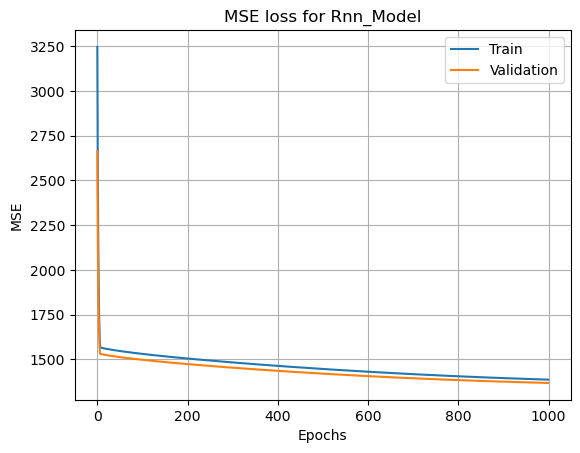

250/250 [==============================] - 0s 582us/step


VALUE ERROR [CNN Model]: Exception encountered when calling layer "conv1d_2" (type Conv1D).

Negative dimension size caused by subtracting 3 from 2 for '{{node conv1d_2/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d_2/Conv1D/ExpandDims, conv1d_2/Conv1D/ExpandDims_1)' with input shapes: [?,1,2,1], [1,3,1,32].

Call arguments received by layer "conv1d_2" (type Conv1D):
  • inputs=tf.Tensor(shape=(None, 2, 1), dtype=float32)

=============== No. Features (2 / 5) - Processing Feature Subspace (1 / 10) ===============
250/250 [==============================] - 0s 705us/step

=============== No. Features (2 / 5) - Processing Feature Subspace (2 / 10) ===============
250/250 [==============================] - 0s 859us/step

=============== No. Features (2 / 5) - Processing Feature Subspace (3 / 10) ===============
250/250 [==============================] - 0s 1ms/step

=======

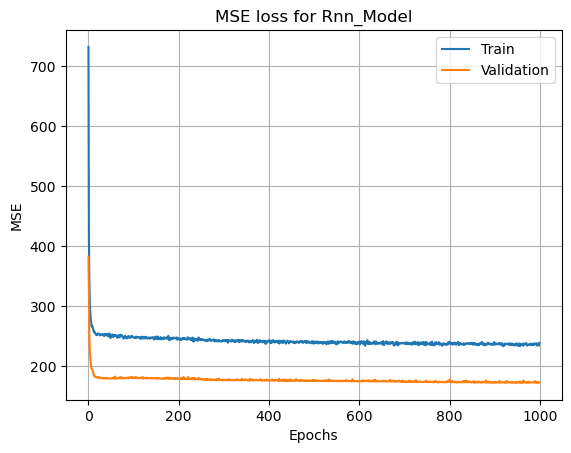

250/250 [==============================] - 0s 906us/step


VALUE ERROR [CNN Model]: Exception encountered when calling layer "max_pooling1d_3" (type MaxPooling1D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling1d_3/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](max_pooling1d_3/ExpandDims)' with input shapes: [?,1,1,32].

Call arguments received by layer "max_pooling1d_3" (type MaxPooling1D):
  • inputs=tf.Tensor(shape=(None, 1, 32), dtype=float32)

=============== No. Features (3 / 5) - Processing Feature Subspace (1 / 10) ===============
250/250 [==============================] - 0s 662us/step

=============== No. Features (3 / 5) - Processing Feature Subspace (2 / 10) ===============
250/250 [==============================] - 0s 1ms/step

=============== No. Features (3 / 5) - Processing Feature Subspace (3 / 10) ===============
250/250 [==============================] - 0s 903us/step

=============== No. Features (3 / 5) - 

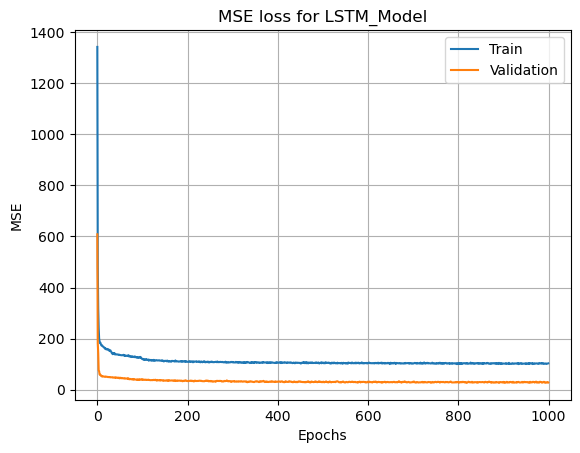

250/250 [==============================] - 0s 1ms/step



=============== No. Features (4 / 5) - Processing Feature Subspace (1 / 5) ===============
250/250 [==============================] - 1s 755us/step

=============== No. Features (4 / 5) - Processing Feature Subspace (2 / 5) ===============
250/250 [==============================] - 0s 1ms/step

=============== No. Features (4 / 5) - Processing Feature Subspace (3 / 5) ===============
250/250 [==============================] - 0s 1ms/step

=============== No. Features (4 / 5) - Processing Feature Subspace (4 / 5) ===============
250/250 [==============================] - 0s 1ms/step

=============== No. Features (4 / 5) - Processing Feature Subspace (5 / 5) ===============
250/250 [==============================] - 0s 1ms/step


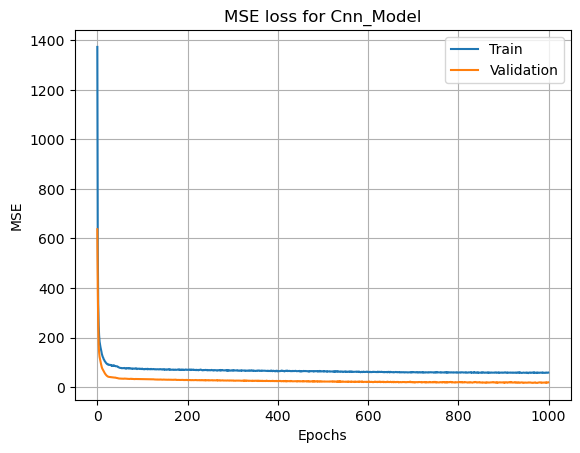

250/250 [==============================] - 0s 735us/step



=============== No. Features (5 / 5) - Processing Feature Subspace (1 / 1) ===============
250/250 [==============================] - 1s 1ms/step



Done!


In [38]:
columns = ['vertical_ground_reaction_force', 'trunk_joint_angle', 'hip_joint_angle', 'knee_joint_angle', 'ankle_joint_angle']

all_results = []

np.random.seed(42)

for num_features in range(1, 6):
    
    result = []
    
    models = reset_models(num_features=num_features)

    feature_subspace = generate_feature_subspaces(input_array=columns, num_features=num_features)
    
    for idx, feature_names in enumerate(feature_subspace):
        print(f"\n=============== No. Features ({num_features} / 5) - Processing Feature Subspace ({idx + 1} / {len(feature_subspace)}) ===============")
        
        feature_names = list(feature_names)
        
        X_subspace = data[feature_names].to_numpy()
        y_subspace = data.joint_moment
        
        tscv = TimeSeriesSplit()

        # Iterate through the splits
        for train_index, test_index in tscv.split(X_subspace):
            X_train_subspace, X_test_subspace = X_subspace[train_index], X_subspace[test_index]
            y_train_subspace, y_test_subspace = y_subspace[train_index], y_subspace[test_index]

        # Training models
        for model in models:
            # In case it's not a neural network
            history = None
            
            # Timer starts
            t0 = datetime.datetime.now()

            try:
                # CNN, RNN, LSTM, Bi-directional LSTM
                model_name = model.name
                history = model.fit(X_train_subspace, y_train_subspace,
                                    validation_data=(X_test_subspace, y_test_subspace),
                                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

            except:
                # LR, DTR, RFR, Lasso, Ridge, BayesianRidge
                model_name = type(model).__name__
                model.fit(X_train_subspace, y_train_subspace)

            # Timer stops
            t1 = datetime.datetime.now()

            elapsed_time = (t1 - t0).total_seconds()

            prediction = model.predict(X_test_subspace)

            mse = mean_absolute_error(prediction, y_test_subspace)

            if history:
                result.append(dict({'num_features': num_features, 'features': feature_names, 'model_name': model_name, 'mse': mse, 'elapsed_time': elapsed_time, 'history': history}))
            else:
                result.append(dict({'num_features': num_features, 'features': feature_names, 'model_name': model_name, 'mse': mse, 'elapsed_time': elapsed_time, 'history': None}))
    
    plot_prediction_ground_truth_best_model(result, models, X_test_subspace, y_test_subspace)

    all_results.append(result)
    
    
print("\nDone!")

In [77]:
generate_feature_selection_table(all_results[0])


| Feature(s) Name | Model Name | Mean Square Error | Elapsed Time (s) |
| :-: | :-: | :-: | :-: |
| vertical_ground_reaction_force | LinearRegression | 17.68623346497776 | 0.000995 |
| | DecisionTreeRegressor | 20.772657998516202 | 0.060573 |
| | RandomForestRegressor | 18.58194175315117 | 4.185363 |
| | Lasso | 17.685871184019042 | 0.000948 |
| | Ridge | 17.68623346415707 | 0.008683 |
| | BayesianRidge | 17.68617764974577 | 0.002562 |
| | Rnn_Model | 17.363447378896513 | 29.20927 |
| | LSTM_Model | 17.33508501336271 | 51.484414 |
| | LSTM_Bidirectional_Model | 17.473842023006906 | 53.310844 |
| trunk_joint_angle | LinearRegression | 19.486090769623967 | 0.001163 |
| | DecisionTreeRegressor | 20.851089571771823 | 0.080505 |
| | RandomForestRegressor | 18.392188495437143 | 4.729796 |
| | Lasso | 29.53904235752656 | 0.000973 |
| | Ridge | 19.546539389636635 | 0.008698 |
| | BayesianRidge | 19.486182264210253 | 0.003047 |
| | Rnn_Model | 16.43401000666801 | 36.875528 |
| | LSTM_Model | 16.498188581286353 | 49.984809 |
| | LSTM_Bidirectional_Model | 16.588356347566283 | 51.146239 |
| hip_joint_angle | LinearRegression | 15.522026595565793 | 0.001234 |
| | DecisionTreeRegressor | 19.447605754766176 | 0.083423 |
| | RandomForestRegressor | 17.057402288687364 | 4.47358 |
| | Lasso | 16.695401543326376 | 0.000955 |
| | Ridge | 15.523005718846484 | 0.000623 |
| | BayesianRidge | 15.52204363919365 | 0.001267 |
| | Rnn_Model | 14.992328460523698 | 37.027567 |
| | LSTM_Model | 15.52549934502082 | 50.186608 |
| | LSTM_Bidirectional_Model | 15.747277384968736 | 50.836847 |
| knee_joint_angle | LinearRegression | 25.91074405292945 | 0.001154 |
| | DecisionTreeRegressor | 26.37974397068366 | 0.073469 |
| | RandomForestRegressor | 23.34127986774073 | 4.386292 |
| | Lasso | 26.653288454728834 | 0.000977 |
| | Ridge | 25.911081701624564 | 0.008726 |
| | BayesianRidge | 25.910887862294082 | 0.003026 |
| | Rnn_Model | 20.502410815024692 | 36.735753 |
| | LSTM_Model | 20.64823926989556 | 49.622311 |
| | LSTM_Bidirectional_Model | 20.5302562022957 | 50.703082 |
| ankle_joint_angle | LinearRegression | 18.867641020001212 | 0.001473 |
| | DecisionTreeRegressor | 13.530444263572754 | 0.074232 |
| | RandomForestRegressor | 11.891394702979058 | 3.789165 |
| | Lasso | 18.798176745755576 | 0.000972 |
| | Ridge | 18.864834941951543 | 0.020822 |
| | BayesianRidge | 18.86760214232318 | 0.005438 |
| | Rnn_Model | 10.171228767993915 | 37.138745 |
| | LSTM_Model | 10.198770651760862 | 49.908427 |
| | LSTM_Bidirectional_Model | 31.016410600581246 | 50.645928 |


In [78]:
generate_feature_selection_table(all_results[1])


| Feature(s) Name | Model Name | Mean Square Error | Elapsed Time (s) |
| :-: | :-: | :-: | :-: |
| vertical_ground_reaction_force, trunk_joint_angle | LinearRegression | 10.91502588573104 | 0.002489 |
| | DecisionTreeRegressor | 7.701396069345326 | 0.17699 |
| | RandomForestRegressor | 6.048661904409151 | 6.620119 |
| | Lasso | 17.685871184019042 | 0.001155 |
| | Ridge | 10.937580695547119 | 0.001447 |
| | BayesianRidge | 10.915056763763008 | 0.002476 |
| | Rnn_Model | 14.445707216215666 | 42.589397 |
| | LSTM_Model | 6.548668558070658 | 68.537155 |
| | LSTM_Bidirectional_Model | 6.689944331458995 | 71.05658 |
| vertical_ground_reaction_force, hip_joint_angle | LinearRegression | 13.81582597200592 | 0.002651 |
| | DecisionTreeRegressor | 5.540329838623976 | 0.181318 |
| | RandomForestRegressor | 4.368723701005791 | 6.644521 |
| | Lasso | 14.486517599987222 | 0.001499 |
| | Ridge | 13.816697437001556 | 0.001493 |
| | BayesianRidge | 13.815858124076021 | 0.002523 |
| | Rnn_Model | 4.5043890261393065 | 41.548632 |
| | LSTM_Model | 6.372777980062047 | 67.916994 |
| | LSTM_Bidirectional_Model | 4.71665416856149 | 70.037034 |
| vertical_ground_reaction_force, knee_joint_angle | LinearRegression | 17.726427136332394 | 0.002846 |
| | DecisionTreeRegressor | 11.595805595922783 | 0.18424 |
| | RandomForestRegressor | 9.468899805542199 | 6.382126 |
| | Lasso | 17.685871184019042 | 0.001155 |
| | Ridge | 17.726405316783225 | 0.001468 |
| | BayesianRidge | 17.72112979675415 | 0.002631 |
| | Rnn_Model | 10.970828285896513 | 42.194183 |
| | LSTM_Model | 9.59029967994949 | 68.174888 |
| | LSTM_Bidirectional_Model | 10.141691661831475 | 69.838919 |
| vertical_ground_reaction_force, ankle_joint_angle | LinearRegression | 17.601628955647357 | 0.00273 |
| | DecisionTreeRegressor | 8.334826316711279 | 0.18282 |
| | RandomForestRegressor | 6.757043951554801 | 6.522714 |
| | Lasso | 17.03965146378763 | 0.001931 |
| | Ridge | 17.59687704926057 | 0.001449 |
| | BayesianRidge | 17.60135065845034 | 0.002459 |
| | Rnn_Model | 15.956601259197742 | 41.662706 |
| | LSTM_Model | 7.2455708019050125 | 68.111218 |
| | LSTM_Bidirectional_Model | 7.941521332592912 | 70.123311 |
| trunk_joint_angle, hip_joint_angle | LinearRegression | 15.176787691682863 | 0.002736 |
| | DecisionTreeRegressor | 14.933345500981199 | 0.196306 |
| | RandomForestRegressor | 12.181861988396209 | 7.27571 |
| | Lasso | 16.695401543326376 | 0.001213 |
| | Ridge | 15.173000288407398 | 0.003155 |
| | BayesianRidge | 15.176700074720477 | 0.005211 |
| | Rnn_Model | 11.777763477671687 | 41.947019 |
| | LSTM_Model | 31.626751242889256 | 67.589876 |
| | LSTM_Bidirectional_Model | 12.18408589785859 | 70.638937 |
| trunk_joint_angle, knee_joint_angle | LinearRegression | 16.723200685895996 | 0.002777 |
| | DecisionTreeRegressor | 9.856669370131554 | 0.182676 |
| | RandomForestRegressor | 7.990718703308332 | 6.728755 |
| | Lasso | 25.29180244064908 | 0.001292 |
| | Ridge | 16.739293772484537 | 0.001617 |
| | BayesianRidge | 16.72323663718522 | 0.002756 |
| | Rnn_Model | 7.938293857879124 | 42.528949 |
| | LSTM_Model | 31.728824090866254 | 67.927043 |
| | LSTM_Bidirectional_Model | 30.056979990336618 | 70.085565 |
| trunk_joint_angle, ankle_joint_angle | LinearRegression | 11.381739959854713 | 0.002599 |
| | DecisionTreeRegressor | 8.018057506343649 | 0.182418 |
| | RandomForestRegressor | 6.38086131624573 | 6.85531 |
| | Lasso | 18.798176745755576 | 0.001204 |
| | Ridge | 11.38689788434076 | 0.001765 |
| | BayesianRidge | 11.381746361627862 | 0.003076 |
| | Rnn_Model | 6.4176752014478575 | 41.700403 |
| | LSTM_Model | 31.728501710800337 | 68.701581 |
| | LSTM_Bidirectional_Model | 6.871406287882631 | 70.22891 |
| hip_joint_angle, knee_joint_angle | LinearRegression | 14.565703728145609 | 0.002651 |
| | DecisionTreeRegressor | 5.411743180367997 | 0.176407 |
| | RandomForestRegressor | 4.19023119468652 | 6.309942 |
| | Lasso | 15.129520275792128 | 0.001282 |
| | Ridge | 14.567433426894757 | 0.001502 |
| | BayesianRidge | 14.565747187316072 | 0.002514 |
| | Rnn_Model | 3.943040807170451 | 42.007349 |
| | LSTM_Model | 31.728830957321335 | 67.894832 |
| | LSTM_Bidirectional_Model | 4.372173679939548 | 69.60895 |
| hip_joint_angle, ankle_joint_angle | LinearRegression | 8.943195437692253 | 0.002817 |
| | DecisionTreeRegressor | 6.374589298585752 | 0.18959 |
| | RandomForestRegressor | 4.992985698044016 | 6.877828 |
| | Lasso | 9.82463729064231 | 0.001436 |
| | Ridge | 8.940379516884637 | 0.001496 |
| | BayesianRidge | 8.943175613478683 | 0.002518 |
| | Rnn_Model | 5.071190188718216 | 42.442887 |
| | LSTM_Model | 31.728745469955612 | 67.704734 |
| | LSTM_Bidirectional_Model | 4.79408477816905 | 70.806474 |
| knee_joint_angle, ankle_joint_angle | LinearRegression | 15.513287779899233 | 0.002863 |
| | DecisionTreeRegressor | 10.501998519642878 | 0.189979 |
| | RandomForestRegressor | 8.705442699911357 | 6.72799 |
| | Lasso | 18.798176745755573 | 0.001274 |
| | Ridge | 15.51794913939854 | 0.001711 |
| | BayesianRidge | 15.513335327775213 | 0.003049 |
| | Rnn_Model | 9.556014238240255 | 41.953835 |
| | LSTM_Model | 31.729394349960494 | 67.601122 |
| | LSTM_Bidirectional_Model | 9.074627716067953 | 70.694372 |


In [79]:
generate_feature_selection_table(all_results[2])


| Feature(s) Name | Model Name | Mean Square Error | Elapsed Time (s) |
| :-: | :-: | :-: | :-: |
| vertical_ground_reaction_force, trunk_joint_angle, hip_joint_angle | LinearRegression | 10.951076848650214 | 0.002762 |
| | DecisionTreeRegressor | 5.074080835757645 | 0.232234 |
| | RandomForestRegressor | 3.929789017124868 | 9.463722 |
| | Lasso | 14.486517599987222 | 0.001804 |
| | Ridge | 11.006920455805226 | 0.002012 |
| | BayesianRidge | 10.95124159716545 | 0.003615 |
| | Rnn_Model | 4.667158618412705 | 48.442099 |
| | LSTM_Model | 4.710919372267772 | 83.525816 |
| | LSTM_Bidirectional_Model | 4.220341019865454 | 89.298321 |
| vertical_ground_reaction_force, trunk_joint_angle, knee_joint_angle | LinearRegression | 10.86829703942158 | 0.003246 |
| | DecisionTreeRegressor | 5.634302589130248 | 0.244482 |
| | RandomForestRegressor | 4.2241186105839805 | 9.07317 |
| | Lasso | 17.685871184019042 | 0.001328 |
| | Ridge | 10.889316150644744 | 0.003689 |
| | BayesianRidge | 10.868339448642669 | 0.006068 |
| | Rnn_Model | 5.649363480473399 | 53.279065 |
| | LSTM_Model | 4.369200543597028 | 91.105792 |
| | LSTM_Bidirectional_Model | 4.592882027085117 | 95.365099 |
| vertical_ground_reaction_force, trunk_joint_angle, ankle_joint_angle | LinearRegression | 8.830299408551229 | 0.003327 |
| | DecisionTreeRegressor | 5.836767457046309 | 0.263521 |
| | RandomForestRegressor | 4.5889655687779545 | 10.034553 |
| | Lasso | 17.03965146378763 | 0.002388 |
| | Ridge | 8.851953883430062 | 0.004039 |
| | BayesianRidge | 8.830331053165926 | 0.008122 |
| | Rnn_Model | 14.225964668614935 | 48.464578 |
| | LSTM_Model | 4.818881603245598 | 83.162296 |
| | LSTM_Bidirectional_Model | 5.413586224397599 | 87.525894 |
| vertical_ground_reaction_force, hip_joint_angle, knee_joint_angle | LinearRegression | 13.290481316175113 | 0.003135 |
| | DecisionTreeRegressor | 4.484462658084891 | 0.233898 |
| | RandomForestRegressor | 3.359305938315022 | 8.967224 |
| | Lasso | 14.486517599987222 | 0.001811 |
| | Ridge | 13.291884059263307 | 0.001994 |
| | BayesianRidge | 13.290546163492266 | 0.003287 |
| | Rnn_Model | 4.444555146888057 | 48.47077 |
| | LSTM_Model | 3.320134871900196 | 82.781871 |
| | LSTM_Bidirectional_Model | 20.353199899163666 | 86.847439 |
| vertical_ground_reaction_force, hip_joint_angle, ankle_joint_angle | LinearRegression | 8.849447598250066 | 0.003085 |
| | DecisionTreeRegressor | 4.779617421880679 | 0.247902 |
| | RandomForestRegressor | 3.6046741122652177 | 9.85934 |
| | Lasso | 13.32251995027338 | 0.002469 |
| | Ridge | 8.85158255478891 | 0.001703 |
| | BayesianRidge | 8.849472644524914 | 0.002899 |
| | Rnn_Model | 4.329469278075501 | 47.025196 |
| | LSTM_Model | 3.8004163237125432 | 82.294365 |
| | LSTM_Bidirectional_Model | 4.036440017107061 | 87.07375 |
| vertical_ground_reaction_force, knee_joint_angle, ankle_joint_angle | LinearRegression | 14.045408297850122 | 0.003367 |
| | DecisionTreeRegressor | 5.252205901062615 | 0.244302 |
| | RandomForestRegressor | 4.098358391688871 | 9.590284 |
| | Lasso | 17.03965146378763 | 0.002408 |
| | Ridge | 14.049188975790992 | 0.001911 |
| | BayesianRidge | 14.045488353136736 | 0.003106 |
| | Rnn_Model | 5.871011238983679 | 49.082855 |
| | LSTM_Model | 4.6572133756916445 | 83.566891 |
| | LSTM_Bidirectional_Model | 5.287115884329789 | 88.068587 |
| trunk_joint_angle, hip_joint_angle, knee_joint_angle | LinearRegression | 14.121931725676404 | 0.00303 |
| | DecisionTreeRegressor | 4.799177041171462 | 0.236105 |
| | RandomForestRegressor | 3.6728342768856073 | 8.961422 |
| | Lasso | 15.129520571008023 | 0.001546 |
| | Ridge | 14.122256270031357 | 0.001768 |
| | BayesianRidge | 14.121924023785793 | 0.002914 |
| | Rnn_Model | 3.9056083314955012 | 48.298987 |
| | LSTM_Model | 3.865922202357385 | 83.118773 |
| | LSTM_Bidirectional_Model | 15.36720235767677 | 89.156109 |
| trunk_joint_angle, hip_joint_angle, ankle_joint_angle | LinearRegression | 8.734252328697595 | 0.003215 |
| | DecisionTreeRegressor | 5.662111344370609 | 0.246394 |
| | RandomForestRegressor | 4.302516852020843 | 9.715134 |
| | Lasso | 9.824636654866818 | 0.001764 |
| | Ridge | 8.728356792189162 | 0.002171 |
| | BayesianRidge | 8.73420485014884 | 0.003911 |
| | Rnn_Model | 4.412096278177982 | 49.418518 |
| | LSTM_Model | 4.415618226357634 | 83.622196 |
| | LSTM_Bidirectional_Model | 12.978304563378286 | 94.97963 |
| trunk_joint_angle, knee_joint_angle, ankle_joint_angle | LinearRegression | 10.341640918094747 | 0.003377 |
| | DecisionTreeRegressor | 6.301528589124316 | 0.266658 |
| | RandomForestRegressor | 4.858529007659603 | 9.951204 |
| | Lasso | 18.798176745755576 | 0.002406 |
| | Ridge | 10.339730546128088 | 0.001797 |
| | BayesianRidge | 10.34163209035263 | 0.003292 |
| | Rnn_Model | 5.537905620240834 | 51.990648 |
| | LSTM_Model | 5.137782525753504 | 90.09673 |
| | LSTM_Bidirectional_Model | 5.20790617123546 | 90.953954 |
| hip_joint_angle, knee_joint_angle, ankle_joint_angle | LinearRegression | 7.774072959079851 | 0.003181 |
| | DecisionTreeRegressor | 4.9027643421755585 | 0.258153 |
| | RandomForestRegressor | 3.6890061836347523 | 9.709464 |
| | Lasso | 9.824622278430496 | 0.001899 |
| | Ridge | 7.7689232110193265 | 0.00166 |
| | BayesianRidge | 7.774039024980988 | 0.002823 |
| | Rnn_Model | 3.814493163038964 | 51.319879 |
| | LSTM_Model | 3.865400807064705 | 87.868 |
| | LSTM_Bidirectional_Model | 3.9983044001338572 | 91.136565 |


In [80]:
generate_feature_selection_table(all_results[3])


| Feature(s) Name | Model Name | Mean Square Error | Elapsed Time (s) |
| :-: | :-: | :-: | :-: |
| vertical_ground_reaction_force, trunk_joint_angle, hip_joint_angle, knee_joint_angle | LinearRegression | 10.851848927614334 | 0.003449 |
| | DecisionTreeRegressor | 3.8898813927885274 | 0.305318 |
| | RandomForestRegressor | 2.8567764752143483 | 12.227295 |
| | Lasso | 14.486517599987222 | 0.002177 |
| | Ridge | 10.903048149878039 | 0.001671 |
| | BayesianRidge | 10.852064564351167 | 0.00352 |
| | Cnn_Model | 2.817725083545458 | 43.767852 |
| | Rnn_Model | 4.683650151116397 | 58.542449 |
| | LSTM_Model | 3.0173578723095997 | 103.351335 |
| | LSTM_Bidirectional_Model | 3.197842742461289 | 113.257434 |
| vertical_ground_reaction_force, trunk_joint_angle, hip_joint_angle, ankle_joint_angle | LinearRegression | 7.946328187932103 | 0.003469 |
| | DecisionTreeRegressor | 4.450174707358831 | 0.320175 |
| | RandomForestRegressor | 3.374163987354976 | 13.443918 |
| | Lasso | 13.32251995027338 | 0.003136 |
| | Ridge | 7.956104539402291 | 0.001725 |
| | BayesianRidge | 7.946369556832982 | 0.003509 |
| | Cnn_Model | 3.9211741343052293 | 43.922465 |
| | Rnn_Model | 4.360384973231752 | 56.972032 |
| | LSTM_Model | 3.77708352060787 | 106.79241 |
| | LSTM_Bidirectional_Model | 3.7605712061811056 | 121.574163 |
| vertical_ground_reaction_force, trunk_joint_angle, knee_joint_angle, ankle_joint_angle | LinearRegression | 7.465035089371126 | 0.003994 |
| | DecisionTreeRegressor | 4.611478089760905 | 0.334621 |
| | RandomForestRegressor | 3.471426035653985 | 14.240134 |
| | Lasso | 17.03965146378763 | 0.002893 |
| | Ridge | 7.470497911144594 | 0.001731 |
| | BayesianRidge | 7.465040832553008 | 0.003736 |
| | Cnn_Model | 4.434860893535451 | 49.508988 |
| | Rnn_Model | 9.3053733979756 | 66.762003 |
| | LSTM_Model | 3.860563070799531 | 117.887746 |
| | LSTM_Bidirectional_Model | 3.7477614015731544 | 122.145728 |
| vertical_ground_reaction_force, hip_joint_angle, knee_joint_angle, ankle_joint_angle | LinearRegression | 7.583502984058449 | 0.003881 |
| | DecisionTreeRegressor | 4.156076154563423 | 0.319027 |
| | RandomForestRegressor | 3.073881228972196 | 13.923691 |
| | Lasso | 13.32251995027338 | 0.003233 |
| | Ridge | 7.584496270673305 | 0.001982 |
| | BayesianRidge | 7.583511070917148 | 0.00414 |
| | Cnn_Model | 3.551745531321526 | 48.469824 |
| | Rnn_Model | 4.627025706342197 | 65.636527 |
| | LSTM_Model | 3.3149731291046645 | 117.370501 |
| | LSTM_Bidirectional_Model | 3.45246376606642 | 121.512507 |
| trunk_joint_angle, hip_joint_angle, knee_joint_angle, ankle_joint_angle | LinearRegression | 7.641474472683591 | 0.004158 |
| | DecisionTreeRegressor | 4.334857630706273 | 0.327622 |
| | RandomForestRegressor | 3.2289920286630323 | 13.701378 |
| | Lasso | 9.82462124203537 | 0.002389 |
| | Ridge | 7.633428882902626 | 0.011942 |
| | BayesianRidge | 7.641411891553726 | 0.015978 |
| | Cnn_Model | 3.360943095992707 | 48.499647 |
| | Rnn_Model | 3.2307425171746345 | 65.500174 |
| | LSTM_Model | 3.527129920735037 | 117.989566 |
| | LSTM_Bidirectional_Model | 3.329790284895582 | 121.716991 |


In [81]:
generate_feature_selection_table(all_results[4])


| Feature(s) Name | Model Name | Mean Square Error | Elapsed Time (s) |
| :-: | :-: | :-: | :-: |
| vertical_ground_reaction_force, trunk_joint_angle, hip_joint_angle, knee_joint_angle, ankle_joint_angle | LinearRegression | 6.706635510844889 | 0.004615 |
| | DecisionTreeRegressor | 3.7617565323821442 | 0.364287 |
| | RandomForestRegressor | 2.7509295811143324 | 17.407121 |
| | Lasso | 13.32251995027338 | 0.003908 |
| | Ridge | 6.711038780222524 | 0.001946 |
| | BayesianRidge | 6.706645174741869 | 0.00552 |
| | Cnn_Model | 2.8230213117944896 | 51.605491 |
| | Rnn_Model | 3.7374447541574622 | 75.489647 |
| | LSTM_Model | 2.9698415868034527 | 136.13704 |
| | LSTM_Bidirectional_Model | 2.967432352747044 | 141.905697 |


In [71]:
text = """### Features Subset Selection Conclusion

* We tried to use relatively simple model, with roughly same number of parameters, to find the best models and feature subspaces, which are listed below:

| No. Features | Ranking | Model | Feature Sub-space | Mean Square Error | Elapsed Time (s) |
| :-: | :-: | :-: | :-: | :-: | :-: |
"""
most_used_features = {}

for result in all_results:
    min_mse_record, second_min_mse_record, third_min_mse_record = find_three_minimum_MSE_from_subspace_results(result)
    
    for feature in min_mse_record['features']:
        if feature not in most_used_features.keys():
            most_used_features[feature] = 1
        else:
            most_used_features[feature] += 1
    
    for feature in second_min_mse_record['features']:
        if feature not in most_used_features.keys():
            most_used_features[feature] = 1
        else:
            most_used_features[feature] += 1

    for feature in third_min_mse_record['features']:
        if feature not in most_used_features.keys():
            most_used_features[feature] = 1
        else:
            most_used_features[feature] += 1
        
    min_mse_record_features = str(min_mse_record['features']).replace('[', '').replace(']', '').replace("'", "")
    second_min_mse_record_features = str(second_min_mse_record['features']).replace('[', '').replace(']', '').replace("'", "")
    third_min_mse_record_features = str(third_min_mse_record['features']).replace('[', '').replace(']', '').replace("'", "")

    text += f"| {min_mse_record['num_features']} | **1** | **{min_mse_record['model_name']}** | **{min_mse_record_features}** | **{round(min_mse_record['mse'], 3)}** | **{round(min_mse_record['elapsed_time'], 1)}** |\n"
    text += f"|| 2 | {second_min_mse_record['model_name']} | {second_min_mse_record_features} | {round(second_min_mse_record['mse'], 3)} | {round(second_min_mse_record['elapsed_time'], 1)} |\n"
    text += f"|| 3 | {third_min_mse_record['model_name']} | {third_min_mse_record_features} | {round(third_min_mse_record['mse'], 3)} | {round(third_min_mse_record['elapsed_time'], 1)} |\n"

md(text)

### Features Subset Selection Conclusion

* We tried to use relatively simple model, with roughly same number of parameters, to find the best models and feature subspaces, which are listed below:

| No. Features | Ranking | Model | Feature Sub-space | Mean Square Error | Elapsed Time (s) |
| :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | **1** | **Rnn_Model** | **ankle_joint_angle** | **10.171** | **37.1** |
|| 2 | LSTM_Model | ankle_joint_angle | 10.199 | 49.9 |
|| 3 | RandomForestRegressor | ankle_joint_angle | 11.891 | 3.8 |
| 2 | **1** | **Rnn_Model** | **hip_joint_angle, knee_joint_angle** | **3.943** | **42.0** |
|| 2 | RandomForestRegressor | hip_joint_angle, knee_joint_angle | 4.19 | 6.3 |
|| 3 | RandomForestRegressor | vertical_ground_reaction_force, hip_joint_angle | 4.369 | 6.6 |
| 3 | **1** | **LSTM_Model** | **vertical_ground_reaction_force, hip_joint_angle, knee_joint_angle** | **3.32** | **82.8** |
|| 2 | RandomForestRegressor | vertical_ground_reaction_force, hip_joint_angle, knee_joint_angle | 3.359 | 9.0 |
|| 3 | RandomForestRegressor | vertical_ground_reaction_force, hip_joint_angle, ankle_joint_angle | 3.605 | 9.9 |
| 4 | **1** | **Cnn_Model** | **vertical_ground_reaction_force, trunk_joint_angle, hip_joint_angle, knee_joint_angle** | **2.818** | **43.8** |
|| 2 | RandomForestRegressor | vertical_ground_reaction_force, trunk_joint_angle, hip_joint_angle, knee_joint_angle | 2.857 | 12.2 |
|| 3 | LSTM_Model | vertical_ground_reaction_force, trunk_joint_angle, hip_joint_angle, knee_joint_angle | 3.017 | 103.4 |
| 5 | **1** | **RandomForestRegressor** | **vertical_ground_reaction_force, trunk_joint_angle, hip_joint_angle, knee_joint_angle, ankle_joint_angle** | **2.751** | **17.4** |
|| 2 | Cnn_Model | vertical_ground_reaction_force, trunk_joint_angle, hip_joint_angle, knee_joint_angle, ankle_joint_angle | 2.823 | 51.6 |
|| 3 | LSTM_Bidirectional_Model | vertical_ground_reaction_force, trunk_joint_angle, hip_joint_angle, knee_joint_angle, ankle_joint_angle | 2.967 | 141.9 |


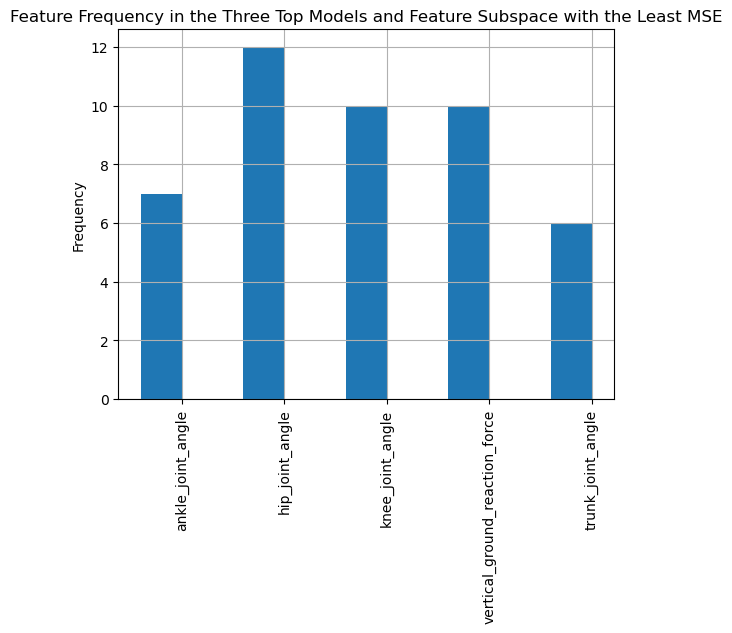

In [66]:
feature_names = most_used_features.keys()
feature_frequency = most_used_features.values()

X_axis = np.arange(len(feature_names))

plt.xticks(X_axis, feature_names)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.bar(X_axis - 0.2, feature_frequency, 0.4)
plt.title('Feature Frequency in the Three Top Models and Feature Subspace with the Least MSE')
plt.grid(True)
plt.show()

* Obviously the subset with all features has the lowest MSE. However, it can be seen that we can reach a great performance by using only **two** features **`Hip Joint Angle`** & **`Knee Joint Angle`** instead of all five.
    

### **Note**:
* We can see that **`Hip Joint Angle`** appears in best subsets almost everytime. It is related to the fact that according to the correlation matrix, it has a **very high** correlation with `Joint Moment`.


![Annotated Matrix](plots/results/Correlation-Matrix-Annotated.jpeg)